In [3]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import os
from scipy.signal import argrelextrema
import xarray
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy
import pickle
import datetime
from ll_xy import lonlat_to_xy
import matplotlib.pyplot as plt
import kuka_tools as kt
from scipy.stats import binned_statistic

In [4]:
directory = '../../data/rothera/netcdfs/20230910'

In [5]:
freqs=['ku','ka']
listfiles = os.listdir(directory)
files = {'ku':sorted([f for f in listfiles if f'Ku-Scat' in f]),
         'ka':sorted([f for f in listfiles if f'Ka-Scat' in f])}

Text(0, 0.5, 'y distance (m)')

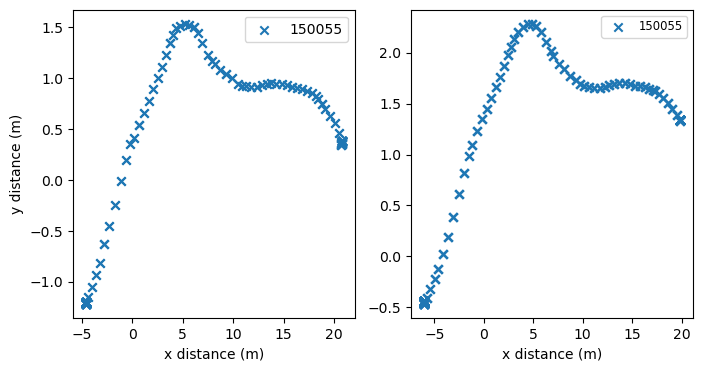

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))

xy_dict = {}

for freq, ax in zip(freqs,[ax1,ax2]):
    
    x,y=kt.plot_pos(files['ku'][0],directory,plot=False)

    x0 = -2300414.994491106; y0 = 923485.871699531

    xy_dict[freq]={}
    
    for f in files[freq]:

        x,y = kt.plot_pos(f,directory,x0=x0,y0=y0,ax=ax)

        xy_dict[freq][f] = (x,y)

ax1.legend()
ax2.legend(ncol=2,fontsize='small')
ax1.set_xlabel('x distance (m)')
ax2.set_xlabel('x distance (m)')
ax1.set_ylabel('y distance (m)')

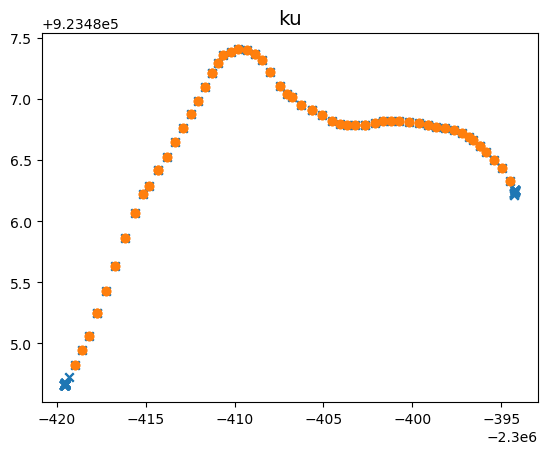

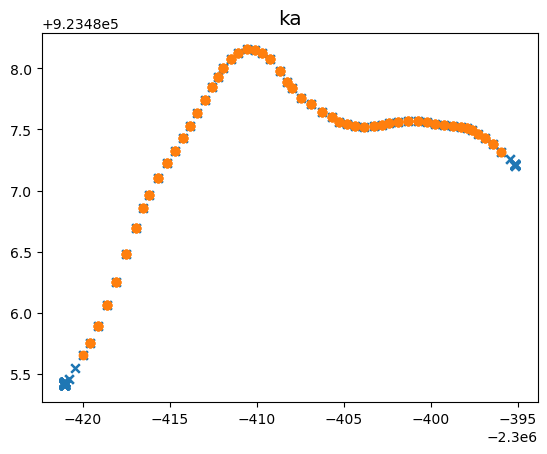

In [37]:
# files['ku'] = ['kuka_stare_decon_Ku-Scat20230910-.nc']
# files['ka'] = ['kuka_stare_decon_Ka-Scat20230910-132410.nc']

lims = {}
lims['ka']={'start':220,'end':420}
lims['ku']={'start':120,'end':238}

for freq in freqs:

    q = kt.plot_pos(files[freq][0],directory)

    plt.scatter(q[0][lims[freq]['start']:lims[freq]['end']],
                q[1][lims[freq]['start']:lims[freq]['end']])
    plt.title(freq,fontsize='x-large')

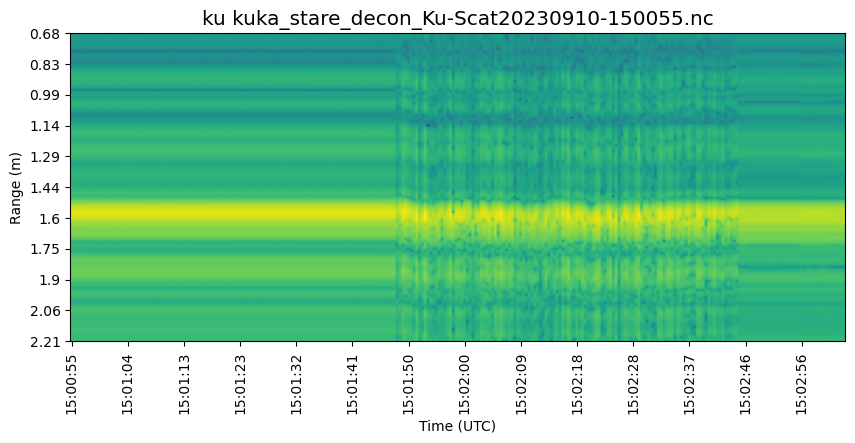

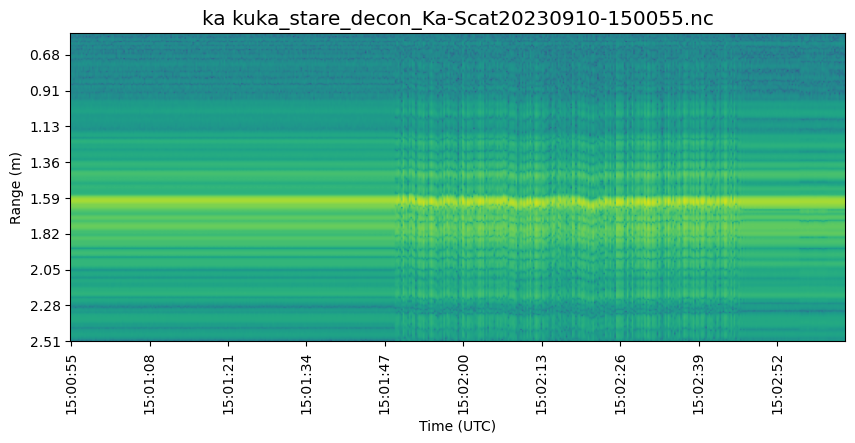

In [38]:
for freq in freqs:
    
    for f in files[freq]:
        kt.plot_file(f,freq.lower(),directory,
                         vlines=[])

In [39]:
nearfardict = {}

for freq in ['ku','ka']:
    
    file = files[freq][0]
    d = Dataset(f'{directory}/{file}')
    near=kt.get_range_index(1.3,d['range'])
    far=kt.get_range_index(2,d['range'])
    nearfardict[freq] = {'near':near,'far':far,'range':np.array(d['range'])[near:far]}
    
pickle.dump(nearfardict,open('nearfar.p','wb'))

In [40]:
data = {}

for freq in ['ku','ka']:

    nrcs_list = []
    for foi in files[freq]:

        x,y=xy_dict[freq][foi]

        d = Dataset(f'{directory}/{foi}')

        time_offset_s=0
        times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x))+datetime.timedelta(seconds=int(time_offset_s)) for x in d['start_time']])

        nrcs = pd.DataFrame(kt.get_nrcs(d,freq.lower()))

        x_ = 0; y_ = 0

        along_track = np.sqrt((x-x_)**2 + (y-y_)**2)
        xdiff = np.diff(x)
        ydiff = np.diff(y)
        speed = np.sqrt(np.square(xdiff)+np.square(ydiff))
        speed=list(speed)+[0]
        nrcs['along_track']=along_track
        nrcs['speed']=speed
        nrcs['xtilt']=np.array(d['cross_tilt'])
        nrcs['atilt']=np.array(d['along_tilt'])
        nrcs = nrcs.iloc[lims[freq]['start']:lims[freq]['end']]

        vv= np.array(d['vv_power_decon0'])[nearfardict[freq]['near']:nearfardict[freq]['far'],
                                           lims[freq]['start']:lims[freq]['end']]
        
        nrcs['vv'] = [vv[:,i] for i in range(vv.shape[1])]
        
#         nrcs = nrcs.iloc[mintime:maxtime]
        
        nrcs = nrcs[nrcs['corr']<0.999]

        nrcs_list.append( nrcs.sort_values('along_track').reset_index() )

    data[freq] = pd.concat(nrcs_list)
    
pickle.dump(data,open('10sep_wfms.p','wb'))

In [142]:
data = {}

for freq in ['ka']:

    nrcs_list = []
    vv_list = []

    foi = file
    x,y=xy_dict[freq][foi]

    d = Dataset(f'{directory}/{foi}')

    time_offset_s=0
    times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x))+datetime.timedelta(seconds=int(time_offset_s)) for x in d['start_time']])

    mintime=a
    maxtime=b

    time_offset_s=0
    times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x))+datetime.timedelta(seconds=int(time_offset_s)) for x in d['start_time']])

    nrcs = pd.DataFrame(kt.get_nrcs(d,freq.lower()))

    x_ = 0; y_ = 0

    along_track = np.sqrt((x-x_)**2 + (y-y_)**2)
    xdiff = np.diff(x)
    ydiff = np.diff(y)
    speed = np.sqrt(np.square(xdiff)+np.square(ydiff))
    speed=list(speed)+[0]
    nrcs['along_track']=along_track
    nrcs['speed']=speed
    nrcs['xtilt']=np.array(d['cross_tilt'])
    nrcs['atilt']=np.array(d['along_tilt'])
    # print(nrcs.shape)
    nrcs = nrcs.iloc[mintime:maxtime]

    vv= np.array(d['vv_power_decon0'])[nearfardict[freq]['near']:nearfardict[freq]['far'],
                                       mintime:maxtime]
    vvp = []
    for i in range(vv.shape[1]):
        vvp.append(vv[:,i])
        
    nrcs['vv']=vvp
    
    nrcs = nrcs[nrcs['corr']<0.9999]


    nrcs = nrcs.sort_values('along_track').reset_index()
    
nrcs.shape

(277, 10)

(1.525, 1.7)

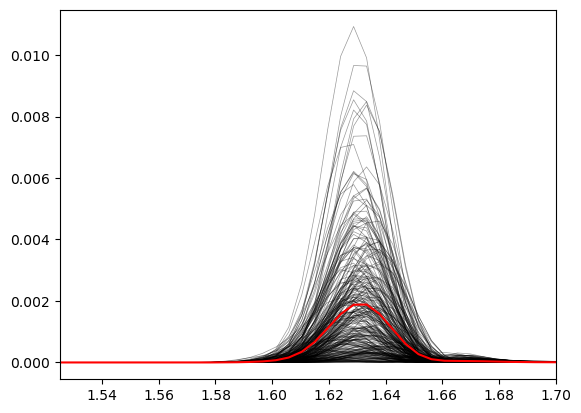

In [143]:
ps = []
max_powers = []
for i in range(nrcs.shape[0]):
    vv_power = nrcs['vv'].iloc[i]
    max_powers.append(ku_ranges[np.argmax(vv_power)])
    ps.append(vv_power)
    plt.plot(ku_ranges,vv_power,color='k',lw=0.5,alpha=0.4)
    
ps=np.array(ps)
mean = np.nanmean(ps,axis=0)
plt.plot(ku_ranges,mean,color='r')

plt.xlim(1.525,1.7)

(array([  0.,   0.,   0.,   2.,   4.,   5., 120.,  98.,  36.,   4.,   8.,
          0.]),
 array([1.58 , 1.587, 1.594, 1.601, 1.608, 1.615, 1.622, 1.629, 1.636,
        1.643, 1.65 , 1.657, 1.664]),
 <BarContainer object of 12 artists>)

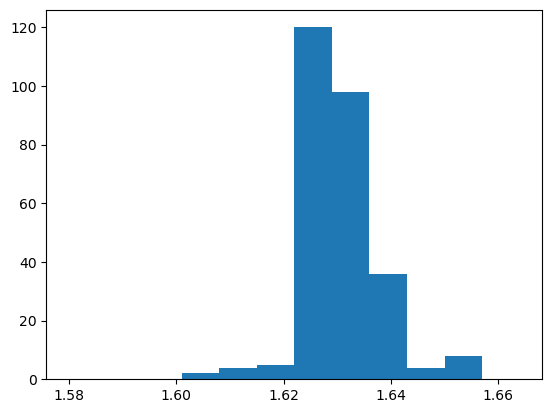

In [145]:
plt.hist(max_powers,np.arange(1.58,1.67,0.007))

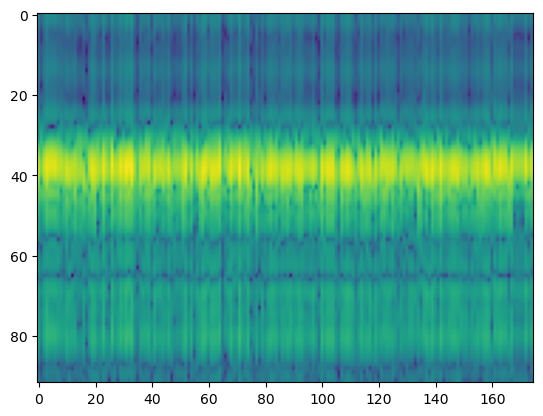

In [109]:
plt.imshow(np.log(ps.T),aspect='auto')

(0.0, 1.0)

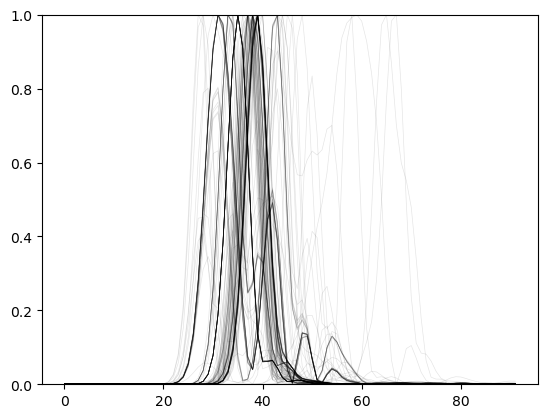

In [53]:
for i in range(q.shape[1]):
    plt.plot(q[:,i]/np.max(q[:,i]),color='k',lw=0.5,alpha=0.1)
    
plt.ylim(0,1)

In [41]:
for freq in freqs:
    
    rel_ranges=data[freq]['range']
    nrcs = data[freq]['nrcs']
    vv = data[freq]['vv']
    
    npeaks=[]
    peak_ranges=[]
    peak_powers_by_range=[]

    for i in np.arange(nrcs.shape[0]):

        power = vv[:,i]

        # Get indices of local maxima
        max_inds = argrelextrema(power, np.greater)[0]
        # Make a list of dictionaries that includes the range_index, range, and power of each local maximum.
        list_of_dicts_for_df = [{'ind':q,'power':power[q],'range':rel_ranges[q]} for q in max_inds]


        # Sort dataframe so most powerful peaks at top
        df = pd.DataFrame(list_of_dicts_for_df).sort_values('power',ascending=False)
        # Take three most powerful peaks
        top_powers_df = df
        #Establish power of most powerful peak
        largest_peak_power = float(top_powers_df['power'].iloc[0])
        top_powers_df['power_ratio'] = top_powers_df['power']/largest_peak_power
        top_powers_df = top_powers_df[top_powers_df['power_ratio']>0.05]
        npeak = top_powers_df.shape[0]
        npeaks.append(npeak)

        # Sort them by range
        df_by_range = top_powers_df.sort_values('range',ascending=True)

        peak_ranges.append(list(df_by_range['range']))
        peak_powers_by_range.append(list(df_by_range['power']))

    nrcs['npeak']=npeaks
    nrcs['peak_ranges']=peak_ranges
    nrcs['peak_powers_by_range']=peak_powers_by_range
    nrcs=nrcs.reset_index().drop(columns=['index'])

    data[freq]['nrcs']=nrcs

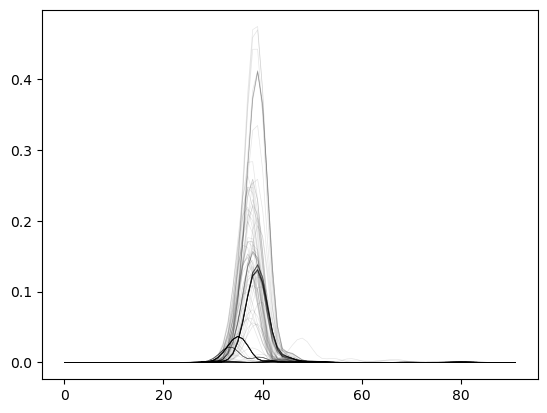

Text(0, 0.5, 'Percentage of Waveforms')

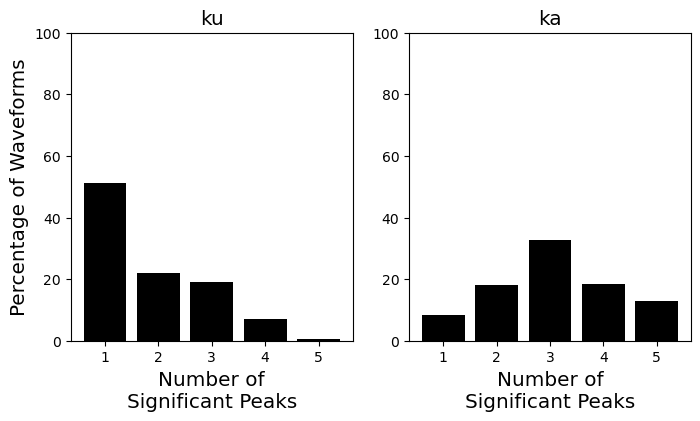

In [42]:
x=np.array([1,2,3,4,5])
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))

for freq,ax in zip(freqs,[ax1,ax2]):
    nlist = data[freq]['nrcs']['npeak']
    
    n=[]
    for i in x:
        n.append(100*len(nlist[nlist==i])/len(nlist))
        
    ax.bar(x,n,alpha=1,color='k')
    ax.set_ylim(0,100)
    ax.set_title(freq,fontsize='x-large')
    ax.set_xlabel('Number of\nSignificant Peaks',fontsize='x-large')
    
ax1.set_ylabel('Percentage of Waveforms',fontsize='x-large')

ku (195, 12)
ka (195, 12)


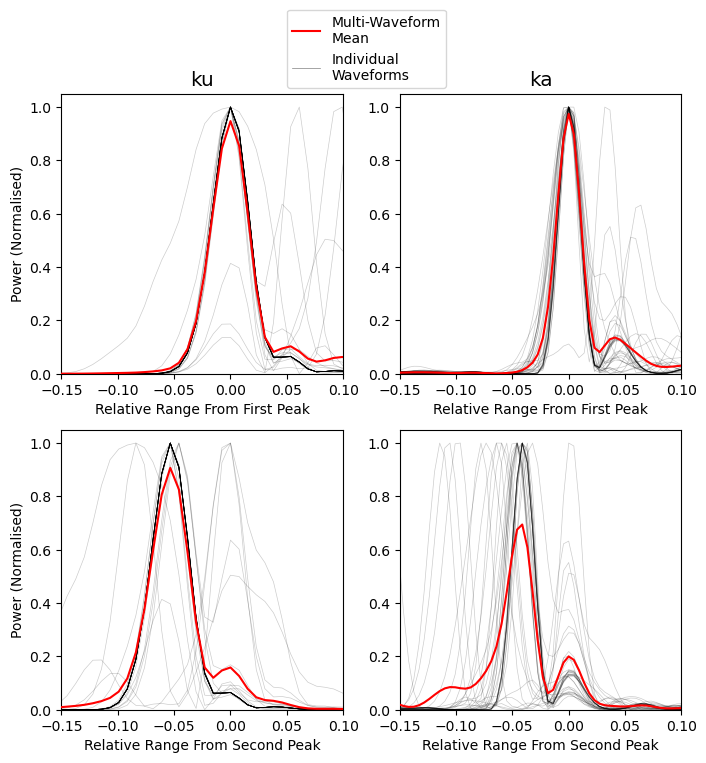

In [43]:
x=np.array([1,2,3,4,5])
fig,axs=plt.subplots(2,2,figsize=(8,8))

ax1,ax2,ax3,ax4=axs.reshape(-1)

for freq,ax in zip(freqs,[ax1,ax2]):
    
    rel_ranges=data[freq]['range']
    nrcs=data[freq]['nrcs']
    vv=data[freq]['vv']

    for peakno in [2]:

        multipeaks=[]
        range_to_nearpeak=[]
        for i in np.arange(nrcs.shape[0]):

            npeaks = nrcs['npeak'][i]


            power = vv[:,i]

            if npeaks==peakno:
                range_to_nearpeak.append(nrcs['peak_ranges'][i][0])
                multipeaks.append(power)


        new_is = []
        for i,r in zip(multipeaks,range_to_nearpeak):
            relative_range=rel_ranges-r
            ax.plot(relative_range,i/np.max(i),color='k',lw=0.5,alpha=0.2)
            df = pd.DataFrame({'x':relative_range,'y':i/np.max(i)}).set_index('x')
            new_is.append(df)
        df = pd.concat(new_is,axis=1).sort_index()
        ave_wfm=np.array(df.mean(axis=1))
        ave_x = np.array(df.mean(axis=1).index)
        max_inds = argrelextrema(ave_wfm, np.greater)[0]
        list_of_dicts_for_df = [{'ind':q,'power':ave_wfm[q],'range':ave_x[q]} for q in max_inds]
        df = pd.DataFrame(list_of_dicts_for_df).sort_values('power',ascending=False).iloc[0:2]
        range_diff = df['range'].iloc[0]-df['range'].iloc[1]
        ax.plot(ave_x,ave_wfm,color='r',zorder=10,label='Multi-Waveform\nMean')
        
        ax.plot([],[],color='k',lw=0.5,alpha=0.5,label='Individual\nWaveforms')
        
        ax.set_ylim(0,1.05)
        ax.set_xlabel('Relative Range From First Peak')
        ax.set_xlim(-0.15,0.1)
        ax.set_title(freq,fontsize='x-large')
        
for freq,ax in zip(freqs,[ax3,ax4]):
    
    rel_ranges=data[freq]['range']
    nrcs=data[freq]['nrcs']
    print(freq,nrcs.shape)
    vv=data[freq]['vv']

    for peakno in [2]:

        multipeaks=[]
        range_to_nearpeak=[]
        for i in np.arange(nrcs.shape[0]):

            npeaks = nrcs['npeak'][i]


            power = vv[:,i]

            if npeaks==peakno:
                range_to_nearpeak.append(nrcs['peak_ranges'][i][1])
                multipeaks.append(power)

        new_is = []
        for i,r in zip(multipeaks,range_to_nearpeak):
            relative_range=rel_ranges-r
            ax.plot(relative_range,i/np.max(i),color='k',lw=0.5,alpha=0.2)
            df = pd.DataFrame({'x':relative_range,'y':i/np.max(i)}).set_index('x')
            new_is.append(df)
        df = pd.concat(new_is,axis=1).sort_index()
        ave_wfm=np.array(df.mean(axis=1))
        ave_x = np.array(df.mean(axis=1).index)
        max_inds = argrelextrema(ave_wfm, np.greater)[0]
        list_of_dicts_for_df = [{'ind':q,'power':ave_wfm[q],'range':ave_x[q]} for q in max_inds]
        df = pd.DataFrame(list_of_dicts_for_df).sort_values('power',ascending=False).iloc[0:2]
        range_diff = df['range'].iloc[0]-df['range'].iloc[1]
        ax.plot(ave_x,ave_wfm,color='r',zorder=10,label='Multi-Waveform\nMean')
        ax.plot([],[],color='k',lw=0.5,alpha=0.5,label='Individual\nWaveforms')
        
        ax.set_ylim(0,1.05)
        ax.set_xlabel('Relative Range From Second Peak')
        ax.set_xlim(-0.15,0.1)
#         ax.set_title(freq)
        
ax1.set_ylabel('Power (Normalised)')
ax3.set_ylabel('Power (Normalised)')
ax1.legend(loc=(0.8,1.02))
plt.show()

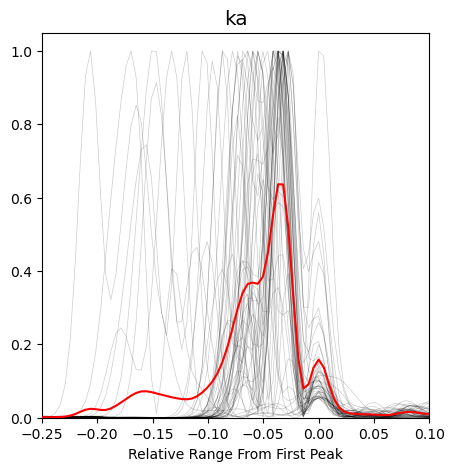

In [43]:
fig,ax=plt.subplots(1,1,figsize=(5,5))


freq = 'ka'


rel_ranges=data[freq]['range']
nrcs=data[freq]['nrcs']
vv=data[freq]['vv']

for peakno in [3]:

    multipeaks=[]
    range_to_nearpeak=[]
    for i in np.arange(nrcs.shape[0]):

        npeaks = nrcs['npeak'][i]

        power = vv[:,i]

        if npeaks==peakno:
            
            fp = nrcs['peak_ranges'][i][0]
            lp = nrcs['peak_ranges'][i][2]
            
#             if lp-fp<0.12:
            

            range_to_nearpeak.append(lp)
            multipeaks.append(power)


    new_is = []
    for i,r in zip(multipeaks,range_to_nearpeak):

        relative_range=rel_ranges-r
        ax.plot(relative_range,i/np.max(i),color='k',lw=0.5,alpha=0.2)
        df = pd.DataFrame({'x':relative_range,'y':i/np.max(i)}).set_index('x')
        new_is.append(df)

    df = pd.concat(new_is,axis=1).sort_index()
    ave_wfm=np.array(df.mean(axis=1))
    ave_x = np.array(df.mean(axis=1).index)
    max_inds = argrelextrema(ave_wfm, np.greater)[0]
    list_of_dicts_for_df = [{'ind':q,'power':ave_wfm[q],'range':ave_x[q]} for q in max_inds]
    df = pd.DataFrame(list_of_dicts_for_df).sort_values('power',ascending=False).iloc[0:2]
    range_diff = df['range'].iloc[0]-df['range'].iloc[1]
    ax.plot(ave_x,ave_wfm,color='r',zorder=10,label='Multi-Waveform\nMean')
        
    ax.plot([],[],color='k',lw=0.5,alpha=0.5,label='Individual\nWaveforms')

    ax.set_ylim(0,1.05)
    ax.set_xlabel('Relative Range From First Peak')
    ax.set_xlim(-0.25,0.1)
    ax.set_title(freq,fontsize='x-large')


In [44]:
# Do some Ka band analysis

for freq in freqs:
    print(freq)
    nrcs=data[freq]['nrcs']

    single_peaks = nrcs[nrcs['npeak']==1]
    double_peaks = nrcs[nrcs['npeak']==2]
    triple_peaks = nrcs[nrcs['npeak']==3]

    # Calculate Ranges Between Double Peaks

    diffs=[]
    for rangelist in double_peaks['peak_ranges']:

        near = rangelist[0]
        far = rangelist[1]
        diffs.append(far-near)

    print(np.nanmean(diffs))

    # Calculate Ranges Between Triple Peaks

    bigdiffs=[]
    smalldiffs=[]
    for rangelist in triple_peaks['peak_ranges']:

        near = rangelist[0]
        med = rangelist[1]
        far = rangelist[-1]
        bigdiffs.append(far-near)
        smalldiffs.append(med-near)


    print(np.nanmean(bigdiffs),np.nanmean(smalldiffs))

ku
0.05283355712890625
0.080108642578125 0.041961669921875
ka
0.038054279077832945
0.081207275390625 0.03460693359375


(array([19., 18.,  6.,  1.,  0.,  0.,  3.,  1.,  1.,  1.]),
 array([0.050354  , 0.06591797, 0.08148193, 0.0970459 , 0.11260986,
        0.12817383, 0.14373779, 0.15930176, 0.17486572, 0.19042969,
        0.20599365]),
 <BarContainer object of 10 artists>)

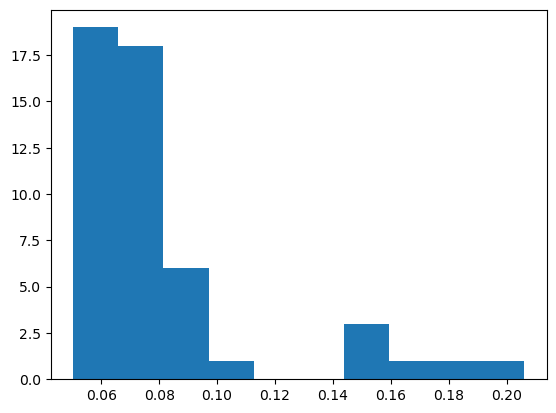

In [45]:
plt.hist(bigdiffs)

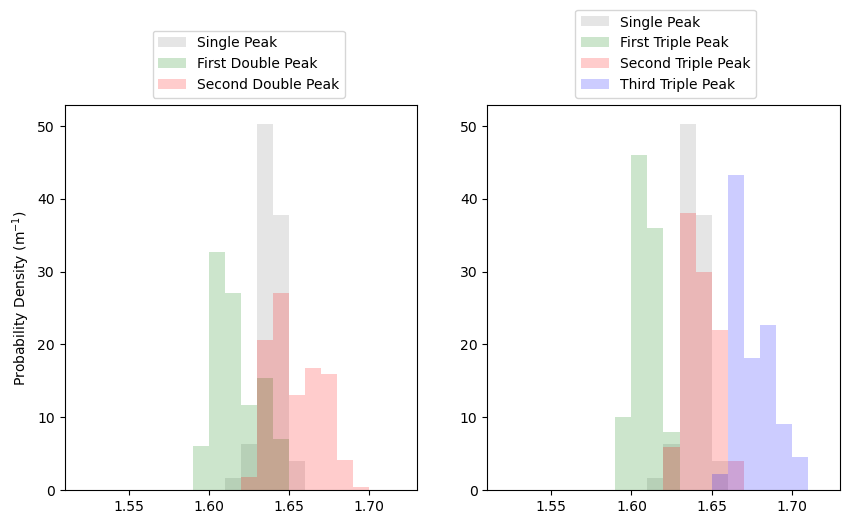

In [46]:
bins=np.arange(1.52,1.7201,0.01)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

sp_ranges = [x[0] for x in single_peaks['peak_ranges']]
ax1.hist(sp_ranges,alpha=0.2,color='grey',bins=bins,density=True,label='Single Peak')

ax2.hist(sp_ranges,alpha=0.2,color='grey',bins=bins,density=True,label='Single Peak')

dp_ranges = [x[0] for x in double_peaks['peak_ranges']]
ax1.hist(dp_ranges,alpha=0.2,color='g',bins=bins,density=True,label='First Double Peak')

dp_ranges = [x[1] for x in double_peaks['peak_ranges']]
ax1.hist(dp_ranges,alpha=0.2,color='r',bins=bins,density=True,label='Second Double Peak')

ax1.legend(loc=(0.25,1.02))

tp_ranges = [x[0] for x in triple_peaks['peak_ranges']]
ax2.hist(tp_ranges,alpha=0.2,color='g',bins=bins,density=True,label='First Triple Peak')

tp_ranges = [x[1] for x in triple_peaks['peak_ranges']]
ax2.hist(tp_ranges,alpha=0.2,color='r',bins=bins,density=True,label='Second Triple Peak')

tp_ranges = [x[2] for x in triple_peaks['peak_ranges']]
ax2.hist(tp_ranges,alpha=0.2,color='b',bins=bins,density=True,label='Third Triple Peak')

ax1.set_ylabel('Probability Density (m$^{-1}$)')

ax2.legend(loc=(0.25,1.02))

0.05283355712890625


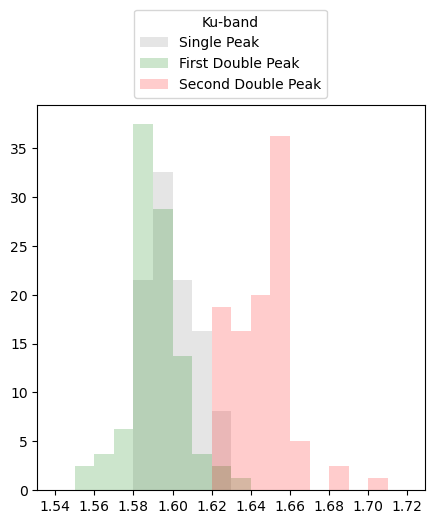

In [47]:
# Do some Ku band analysis

nrcs=data['ku']['nrcs']

single_peaks = nrcs[nrcs['npeak']==1]
double_peaks = nrcs[nrcs['npeak']==2]
triple_peaks = nrcs[nrcs['npeak']==3]

# Calculate Ranges Between Double Peaks

diffs=[]
for rangelist in double_peaks['peak_ranges']:
    
    near = rangelist[0]
    far = rangelist[1]
    diffs.append(far-near)
    
print(np.nanmean(diffs))

bins=np.arange(1.54,1.7201,0.01)

fig,ax1 = plt.subplots(1,1,figsize=(5,5))

sp_ranges = [x[0] for x in single_peaks['peak_ranges']]
ax1.hist(sp_ranges,alpha=0.2,color='grey',bins=bins,density=True,label='Single Peak')

dp_ranges = [x[0] for x in double_peaks['peak_ranges']]
ax1.hist(dp_ranges,alpha=0.2,color='g',bins=bins,density=True,label='First Double Peak')

dp_ranges = [x[1] for x in double_peaks['peak_ranges']]
ax1.hist(dp_ranges,alpha=0.2,color='r',bins=bins,density=True,label='Second Double Peak')

ax1.legend(loc=(0.25,1.02),title='Ku-band')

ax1.set_xticks(bins[::2])

plt.show()